In [ ]:
%pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.2-py3-none-any.whl size=198469 sha256=e9c6e386264b0be1bfafd3b8dcdf09537b5b5123db1acea140275f0744423ba1
  Stored in directory: /root/.cache/pip/wheels/77/c2/20/34d1f15b41b701ba69f42a32304825810d680754d509f91391
Successfully built pyod


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import typing as t

from pyod.utils.data import generate_data
from pyod.models.knn import KNN

from sklearn.metrics import confusion_matrix, roc_curve
from scipy.linalg import solve_triangular

In [ ]:
class Metrics:
    @staticmethod
    def balanced_accuracy(labels: np.ndarray, predictions: np.ndarray, message: str) -> float:
        tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()

        # compute recall, sensitivity
        tpr = tp / (tp + fn)
        # compute specificity
        tnr = tn / (tn + fp)
        # compute balanced accuracy
        ba = (tpr + tnr) / 2

        print(f"Balanced accuracy for {message}: {ba}")

        return ba


    @staticmethod
    def roc(labels: np.ndarray, predictions: np.ndarray) -> None:
        fpr, tpr, _ = roc_curve(labels, predictions, pos_label=1)

        plt.plot(fpr, tpr)
        plt.show()

    @staticmethod
    def generate(labels: np.ndarray, predictions: np.ndarray, message: str) -> None:
        Metrics.balanced_accuracy(labels, predictions, message)
        Metrics.roc(labels, predictions)

In [ ]:
def generate_dataset() -> t.Tuple:
    train_data, test_data, train_labels, test_labels = generate_data(n_train=400, n_test=100, n_features=2, contamination=0.1)

    plt.scatter(train_data[:, 0], train_data[:, 1], color="blue")
    plt.scatter(test_data[:, 0], test_data[:, 1], color="orange")
    plt.show()

    return train_data, test_data, train_labels, test_labels

In [ ]:
def knn(data: np.ndarray, contamination: t.Optional[float] = 0.1) -> np.ndarray:
    knn_ = KNN(contamination=contamination)
    knn_.fit(data)

    return knn_.labels_

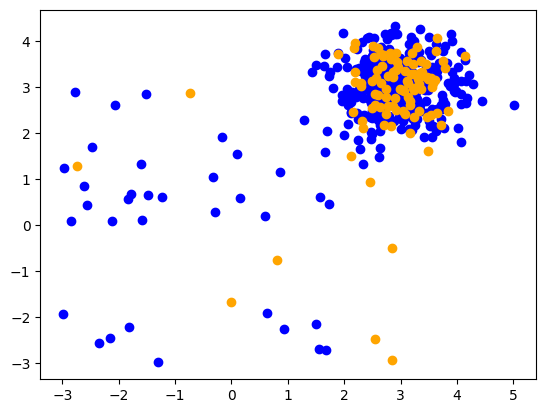

In [ ]:
# generate the dataset
train_data, test_data, train_labels, test_labels = generate_dataset()

Balanced accuracy for KNN contamination = 0.1 train: 0.9583333333333334


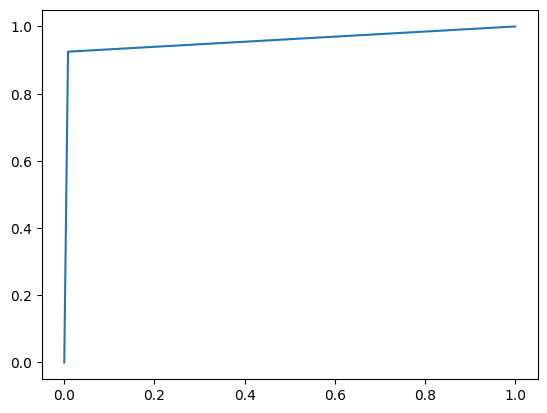

Balanced accuracy for KNN contamination = 0.1 test: 0.9444444444444444


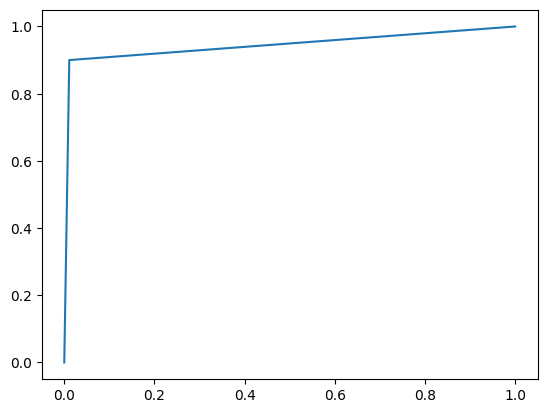

In [ ]:
# use KNN with default settings and contamination = 0.1
train_knn_default_labels = knn(train_data)
test_knn_default_labels = knn(test_data)

Metrics.generate(train_labels, train_knn_default_labels, "KNN contamination = 0.1 train")
Metrics.generate(test_labels, test_knn_default_labels, "KNN contamination = 0.1 test")

Balanced accuracy for KNN contamination = 0.3 train: 0.8888888888888888


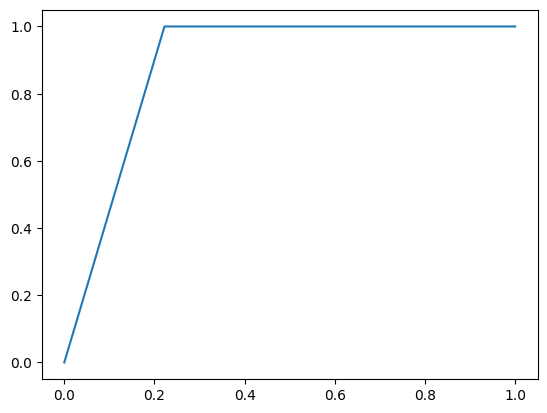

Balanced accuracy for KNN contamination = 0.3 test: 0.8888888888888888


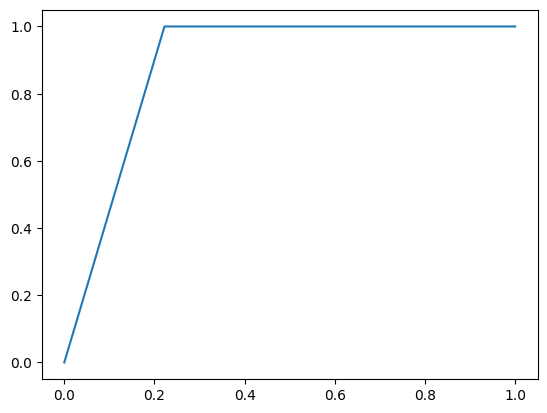

In [ ]:
# use KNN with default settings and contamination = 0.3
train_knn_custom_labels = knn(train_data, contamination=0.3)
test_knn_custom_labels = knn(test_data, contamination=0.3)

Metrics.generate(train_labels, train_knn_custom_labels, "KNN contamination = 0.3 train")
Metrics.generate(test_labels, test_knn_custom_labels, "KNN contamination = 0.3 test")

In [ ]:
def solve_system_chol(Σ: np.ndarray, b: np.ndarray) -> np.ndarray:
    """
    Given a system Σ @ x = b, solve it using the Cholesky decomposition:

    1. Σ = L @ L.T
    2. L @ L.T @ x = b
    3. Let y = L.T @ x
    4. Find y by solving L @ y = b
    4. Find x by solving L.T @ x = y
    """
    L = np.linalg.cholesky(Σ)
    y = solve_triangular(L, b)
    x = solve_triangular(L.T, y)

    return x

Balanced accuracy for Z-scores for univariate data: 0.9388888888888889


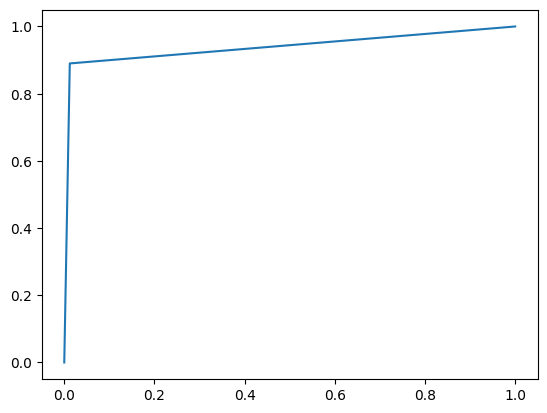

In [ ]:
def z_scores_unidimensional(contamination: float = 0.1) -> None:
    data, labels = generate_data(n_train=1000, train_only=True, contamination=contamination, n_features=1)

    scores = np.abs(data - np.mean(data)) / np.std(data)

    # quantile will give you the value under which a % q
    # of the data is located at, meaning that (1-contamination)% of
    # the samples will be classified as normal
    threshold = np.quantile(scores, 1 - contamination)

    # if the z-score is bigger than the threshold, it means it is
    # an anomaly and it will be labeled with 1, otherwise 0
    predictions = [int(label) for [label] in (scores > threshold)]
    predictions = np.asarray(predictions)

    Metrics.generate(labels, predictions, "Z-scores for univariate data")

z_scores_unidimensional()

Balanced accuracy for Z-scores for multivariate data: : 0.9888888888888889


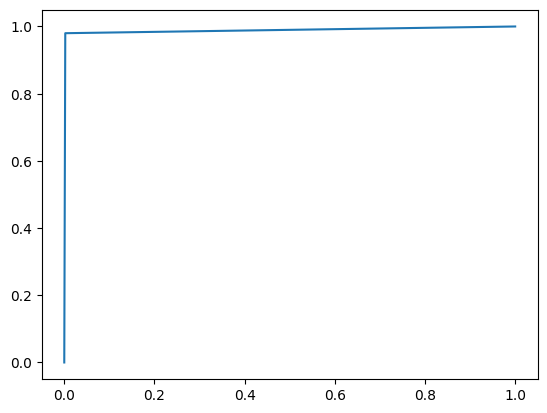

In [ ]:
def z_scores_multidimensional(
    samples: int = 1000,
    features: int = 10,
    contamination: float = 0.1,
) -> None:
    data, labels = generate_data(n_train=samples, train_only=True, contamination=contamination, n_features=features)

    # compute the mean for each feature
    mean = np.mean(data, axis=0)
    # compute the covariance matrix
    Σ = np.cov(data, rowvar=False)

    # transpose the data, because the desired shape is (features, samples)
    X = data.T

    z_scores = []

    for i in range(samples):
        x = X[:, i]

        # solve Σ @ w = (x - mean)
        w = solve_system_chol(Σ, (x - mean))
        # compute (x - mean).T @ w
        z_score = np.transpose(x - mean) @ w

        z_scores.append(z_score)

    z_scores_threshold = np.quantile(z_scores, q=(1 - contamination))

    predictions = [int(label) for label in z_scores > z_scores_threshold]
    predictions = np.asarray(predictions)

    Metrics.generate(labels, predictions, "Z-scores for multivariate data: ")

z_scores_multidimensional()

Balanced accuracy for Z-scores for multivariate custom data: : 0.4960041556780948


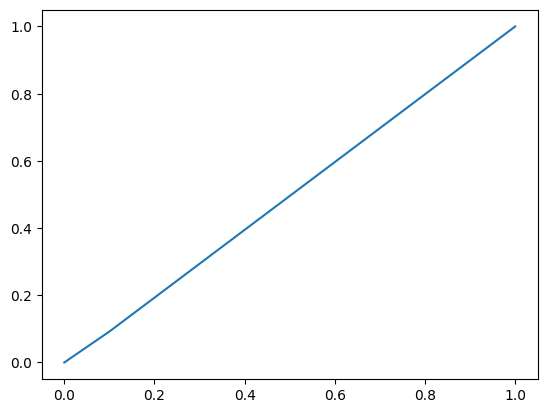

In [ ]:
def z_score_multidimensional_custom(
    samples: int = 1000,
    features: int = 10,
    contamination: float = 0.1,
) -> None:
    # generate a random mean
    mean = np.random.random(size=features)

    # generate a random covariance matrix
    L = np.random.random(size=(features, features))
    Σ = L @ L.T

    # generate the dataset from a standard normal
    X = np.random.multivariate_normal(mean=np.zeros(features), cov=np.eye(features), size=(samples))
    X = mean[:, np.newaxis] + L @ X.T
    # generate the labels for the data
    labels = np.random.choice([0, 1], size=(samples), p=[(1 - contamination), contamination])

    z_scores = []

    for i in range(samples):
        x = X[:, i]

        # solve Σ @ w = (x - mean)
        y = solve_triangular(L, (x - mean))
        w = solve_triangular(L.T, y)
        # compute (x - mean).T @ w
        z_score = np.transpose(x - mean) @ w

        z_scores.append(z_score)

    z_scores_threshold = np.quantile(z_scores, q=(1 - contamination))

    predictions = [int(label) for label in z_scores > z_scores_threshold]
    predictions = np.asarray(predictions)

    Metrics.generate(labels, predictions, "Z-scores for multivariate custom data: ")

z_score_multidimensional_custom()